In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/goodreads-books-reviews-290312/goodreads_test.csv
/kaggle/input/goodreads-books-reviews-290312/goodreads_sample_submission.csv
/kaggle/input/goodreads-books-reviews-290312/goodreads_train.csv


## Step 1: Data Analysis

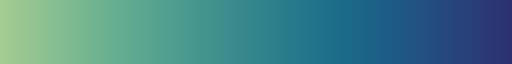

In [2]:
import seaborn as sns
sns.color_palette("crest", as_cmap=True)

### Step 1.1 : Import Data

In [3]:
df = pd.read_csv("/kaggle/input/goodreads-books-reviews-290312/goodreads_train.csv")

In [4]:
df.head()

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,This is a special book. It started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1
1,8842281e1d1347389f2ab93d60773d4d,16981,a5d2c3628987712d0e05c4f90798eb67,3,Recommended by Don Katz. Avail for free in Dec...,Mon Dec 05 10:46:44 -0800 2016,Wed Mar 22 11:37:04 -0700 2017,NaN,NaN,1,0
2,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,3,"A fun, fast paced science fiction thriller. I ...",Tue Nov 15 11:29:22 -0800 2016,Mon Mar 20 23:40:27 -0700 2017,Sat Mar 18 23:22:42 -0700 2017,Fri Mar 17 23:45:40 -0700 2017,22,0
3,8842281e1d1347389f2ab93d60773d4d,27161156,ced5675e55cd9d38a524743f5c40996e,0,Recommended reading to understand what is goin...,Wed Nov 09 17:37:04 -0800 2016,Wed Nov 09 17:38:20 -0800 2016,NaN,NaN,5,1
4,8842281e1d1347389f2ab93d60773d4d,25884323,332732725863131279a8e345b63ac33e,4,"I really enjoyed this book, and there is a lot...",Mon Apr 25 09:31:23 -0700 2016,Mon Apr 25 09:31:23 -0700 2016,Sun Jun 26 00:00:00 -0700 2016,Sat May 28 00:00:00 -0700 2016,9,1


### Step 1.2: Data Analysis

#### Step 1.2.1: Understand the length
This is made as transformers generally can only handle up to a certain length

In [26]:
df["review_text_length"] = df["review_text"].str.len()

In [6]:
df['review_text_length_bin'] = pd.qcut(df['review_text_length'], 10) 

In [7]:
df_9q = df[df['review_text_length'] < 2682]

<AxesSubplot:xlabel='review_text_length', ylabel='review_text_length_bin'>

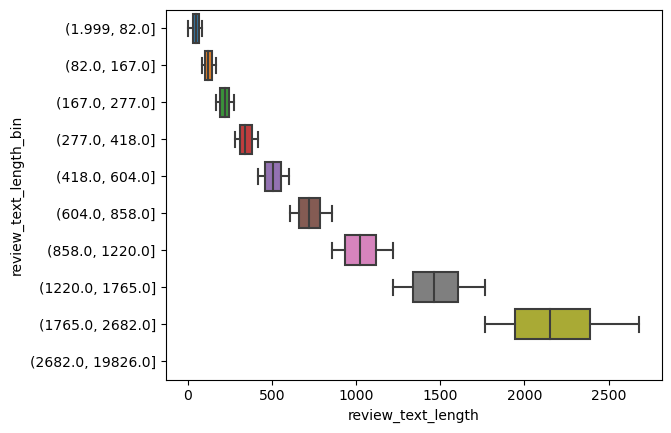

In [8]:
sns.boxplot(data=df_9q, x="review_text_length", y="review_text_length_bin")

In [41]:
def define_long_text(text):
    if len(text) > 512:
        return 1
    else:
        return 0

In [42]:
df['long_text_ind'] = df['review_text'].apply(define_long_text)

### Step 1.3: Getting the data

In [44]:
df_text = df["review_text"]

In [45]:
df_text

0         This is a special book. It started slow for ab...
1         Recommended by Don Katz. Avail for free in Dec...
2         A fun, fast paced science fiction thriller. I ...
3         Recommended reading to understand what is goin...
4         I really enjoyed this book, and there is a lot...
                                ...                        
899995    3.5 stars. \n Jenna is a popular YA author and...
899996    This was a quick read for me. I have read a lo...
899997    ** spoiler alert ** \n 3.5 stars. \n This book...
899998    ** spoiler alert ** \n Another fun read from M...
899999    ** spoiler alert ** \n 3.5 stars \n I liked it...
Name: review_text, Length: 900000, dtype: object

In [46]:
sample_text = df_text[0]
long_text = df_text[4]
train_text = df_text[:300]
eval_text = df_text[-100:]

## Step 2: Importing Text Model

In [47]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, f1_score
from transformers import Trainer, TrainingArguments

In [48]:
# Defining the type of model to be used, here we will use Encoder-based Transformers Model
model_ckpt = "distilbert-base-uncased"

### Step 2.1: Loading Tokenizer

In [14]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [28]:
sample_text

'This is a special book. It started slow for about the first third, then in the middle third it started to get interesting, then the last third blew my mind. This is what I love about good science fiction - it pushes your thinking about where things can go. \n It is a 2015 Hugo winner, and translated from its original Chinese, which made it interesting in just a different way from most things I\'ve read. For instance the intermixing of Chinese revolutionary history - how they kept accusing people of being "reactionaries", etc. \n It is a book about science, and aliens. The science described in the book is impressive - its a book grounded in physics and pretty accurate as far as I could tell. (view spoiler)[Though when it got to folding protons into 8 dimensions I think he was just making stuff up - interesting to think about though. \n But what would happen if our SETI stations received a message - if we found someone was out there - and the person monitoring and answering the signal o

In [40]:
# test
# this is to see the actual words used
encoded_text_tokens = tokenizer(sample_text).tokens()

# to get the input IDs and attention mask
encoded_text = tokenizer(sample_text)

In [36]:
len(encoded_text_tokens)

452

In [37]:
encoded_text_tokens[:20]

['[CLS]',
 'this',
 'is',
 'a',
 'special',
 'book',
 '.',
 'it',
 'started',
 'slow',
 'for',
 'about',
 'the',
 'first',
 'third',
 ',',
 'then',
 'in',
 'the',
 'middle']

### Step 2.2:  Loading Model

In [ ]:
# Defining number of labels and the model
num_labels = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

In [ ]:
# defining the metrics used for fine-tuning
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [ ]:
# defining the training arguments
batch_size = 64
logging_steps = len(train_text) // batch_size
model_name = f"{model_ckpt}-finetuned-goodreads-reviews"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2, 
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size, 
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

In [ ]:
trainer = Trainer(model=model, 
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=train_text, 
                  eval_dataset=eval_text, 
                  tokenizer=tokenizer)